In [ ]:
! pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['BTC-USD.csv']))

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-14,11429.047852,11539.977539,11307.831055,11429.506836,11429.506836,24103426719
1,2020-10-15,11426.602539,11569.914063,11303.603516,11495.349609,11495.349609,24487233058
2,2020-10-16,11502.828125,11540.061523,11223.012695,11322.123047,11322.123047,25635480772
3,2020-10-17,11322.123047,11386.261719,11285.345703,11358.101563,11358.101563,19130430174
4,2020-10-18,11355.982422,11483.359375,11347.578125,11483.359375,11483.359375,18283314340
...,...,...,...,...,...,...,...
359,2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,34800873924
360,2021-10-09,53929.781250,55397.945313,53735.144531,54968.222656,54968.222656,32491211414
361,2021-10-10,54952.820313,56401.304688,54264.257813,54771.578125,54771.578125,39527792364
362,2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,42637331698


In [ ]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [ ]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2020-10-14,0.002058
2020-10-15,0.003320
2020-10-16,0.000000
2020-10-17,0.000689
2020-10-18,0.003090


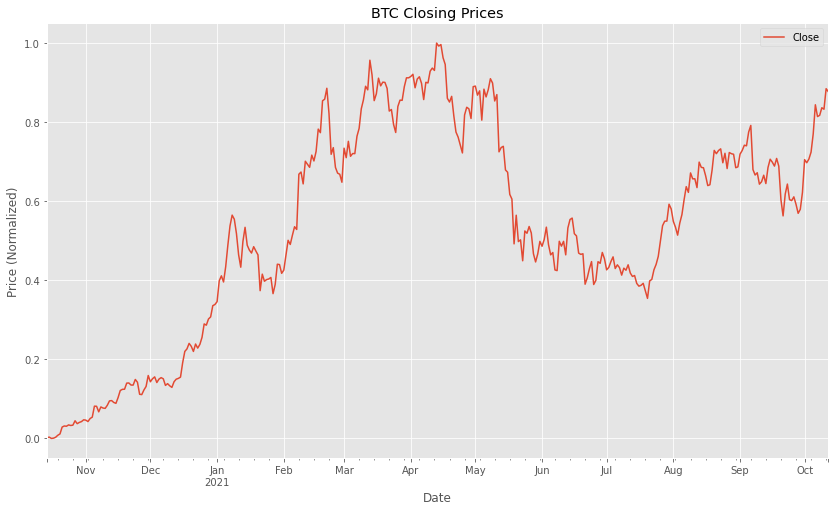

In [ ]:

# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

Functions to prepare the data for LSTM

In [ ]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [ ]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

Splitting the Data

In [ ]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Modeling - LSTM (RNN

Creating the Neural Network

In [ ]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1

In [ ]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Fitting and Training the RNN

In [ ]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
10/10 [==============================] - 12s 232ms/step - loss: 0.3584 - accuracy: 0.2260 - val_loss: 0.4105 - val_accuracy: 0.2121
Epoch 2/800
10/10 [==============================] - 1s 105ms/step - loss: 0.3142 - accuracy: 0.2432 - val_loss: 0.3495 - val_accuracy: 0.2121
Epoch 3/800
10/10 [==============================] - 1s 103ms/step - loss: 0.2603 - accuracy: 0.2432 - val_loss: 0.2727 - val_accuracy: 0.2121
Epoch 4/800
10/10 [==============================] - 1s 104ms/step - loss: 0.1954 - accuracy: 0.2432 - val_loss: 0.1822 - val_accuracy: 0.2121
Epoch 5/800
10/10 [==============================] - 1s 104ms/step - loss: 0.1323 - accuracy: 0.2432 - val_loss: 0.0993 - val_accuracy: 0.2121
Epoch 6/800
10/10 [==============================] - 1s 106ms/step - loss: 0.0935 - accuracy: 0.1610 - val_loss: 0.0518 - val_accuracy: 0.0909
Epoch 7/800
10/10 [==============================] - 1s 105ms/step - loss: 0.0754 - accuracy: 0.0719 - val_loss: 0.0319 - val_accuracy: 0.090


Plotting the Accuracy and Loss

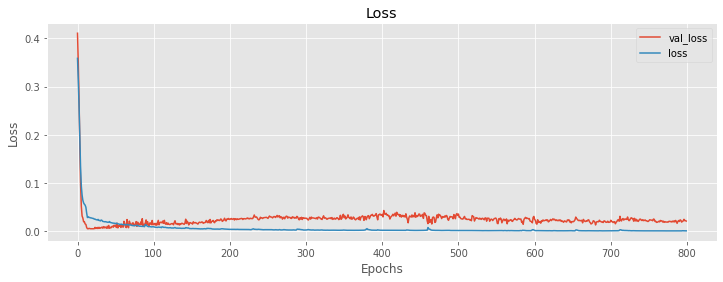

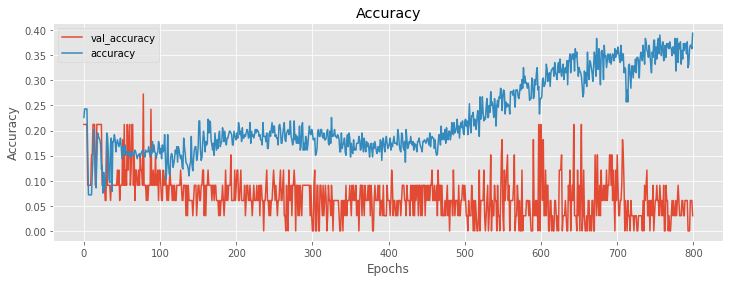

In [ ]:
visualize_training_results(res)

# Visualizing the Predictions

Validating the Model

Plotting the difference between the Actual closing prices and the Predicted prices

Predicted Prices:
 [[45217.40536815025], [45849.457906956], [46145.63767189998], [47439.825086312376], [47644.582166400556], [47644.05964442139], [48117.16286331302], [48779.49679491173], [48169.22533598776], [48069.07217972996]]

Actual Prices:
 [[48199.953125], [49112.902344], [51514.8125], [55361.449219], [53805.98437500001], [53967.84765599999], [54968.22265599999], [54771.578125], [57484.789063], [57102.19140599998]]


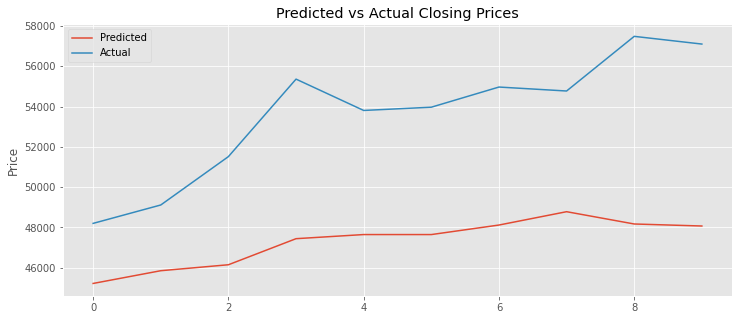

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

Predicting/Forecasting the future prices

                   Close
2021-10-12  52278.223101
2021-10-13  51849.114367
2021-10-14  50418.470959
2021-10-15  49624.380622
2021-10-16  48516.559381
2021-10-17  48505.051456
2021-10-18  47682.564538
2021-10-19  47456.421380
2021-10-20  47356.003852
2021-10-21  47496.674234


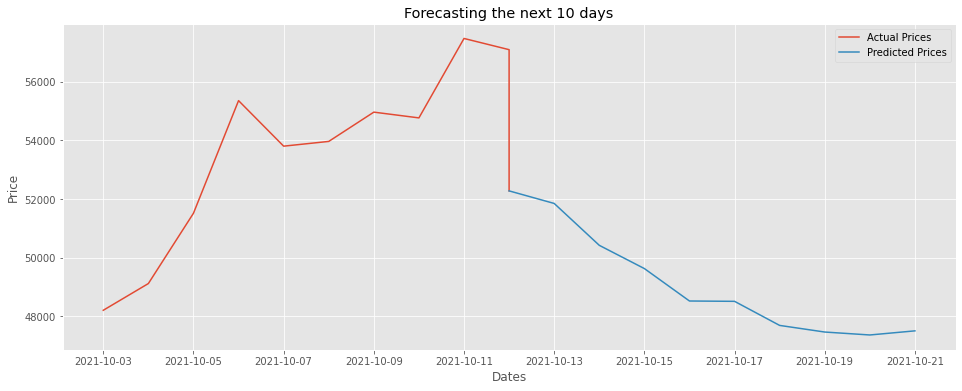

In [ ]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()